# Learning to import mseed files and visualize/correlation with python

In [1]:
import obspy
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
in_dir = '../../banner/data/out/'

In [3]:
for i, f in enumerate(os.listdir(in_dir)):
    if i == 0:
        st = obspy.read(os.path.join(in_dir, f))
    else:
        st += obspy.read(os.path.join(in_dir, f))

In [4]:
# sort
st.sort(['starttime'])

33 Trace(s) in Stream:

.c0BE4..p1 | 2021-12-02T22:20:13.975000Z - 2021-12-02T23:59:59.995000Z | 200.0 Hz, 1197205 samples
...
(31 other traces)
...
.c0BE4..p0 | 2021-12-16T00:00:00.000000Z - 2021-12-16T18:47:18.720000Z | 200.0 Hz, 13527745 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

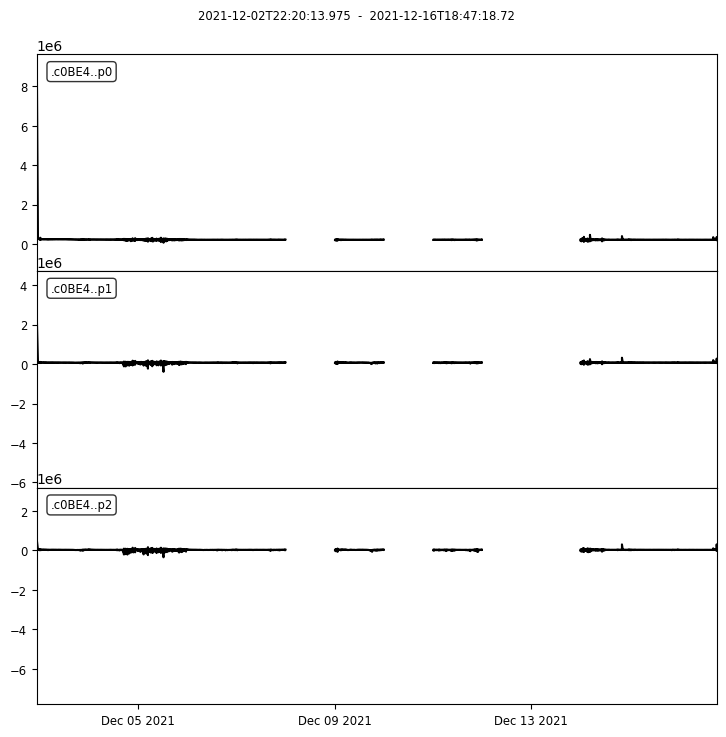

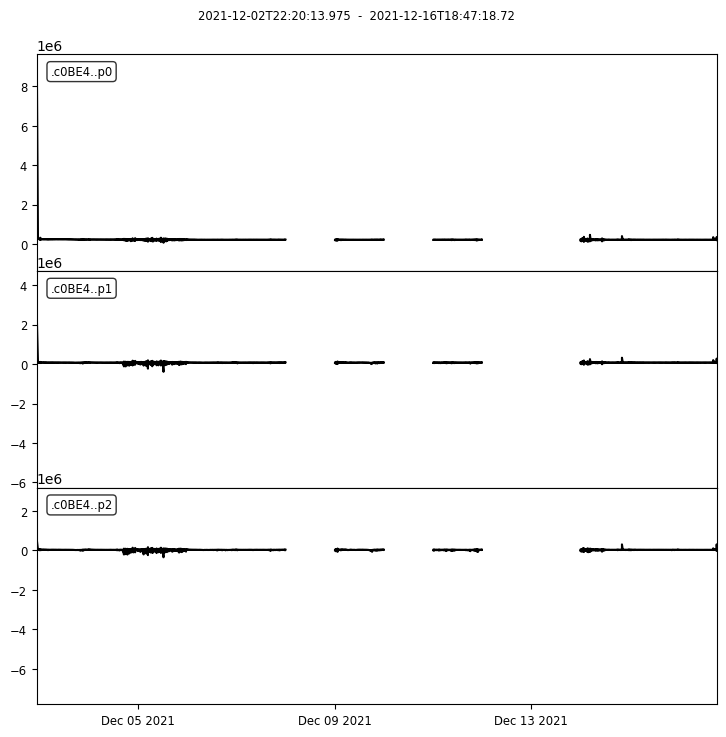

In [5]:
st.plot()

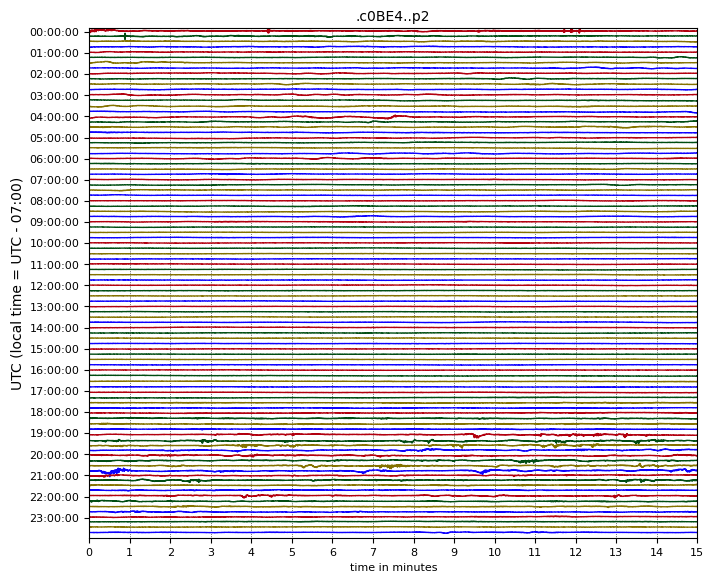

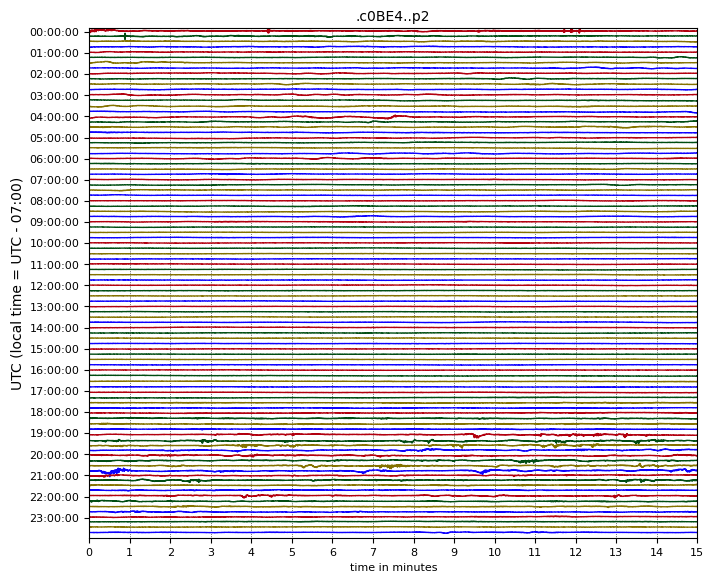

In [6]:
st[4].plot(type='dayplot')

In [7]:
st.filter('lowpass', freq = 10)

33 Trace(s) in Stream:

.c0BE4..p1 | 2021-12-02T22:20:13.975000Z - 2021-12-02T23:59:59.995000Z | 200.0 Hz, 1197205 samples
...
(31 other traces)
...
.c0BE4..p0 | 2021-12-16T00:00:00.000000Z - 2021-12-16T18:47:18.720000Z | 200.0 Hz, 13527745 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [8]:
p0arr = st.select(channel = 'p0')[1].data

In [9]:
p1arr = st.select(channel = 'p1')[1].data

In [10]:

p0arr = p0arr - p0arr.mean()
p1arr = p1arr - p1arr.mean()

In [11]:
p0arr.mean()

3.1070214592748217e-10

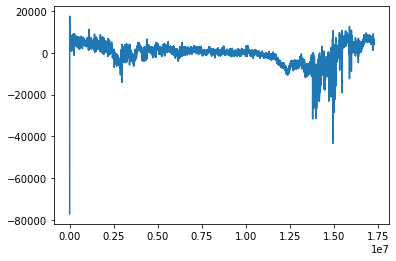

In [12]:
plt.plot(p1arr)

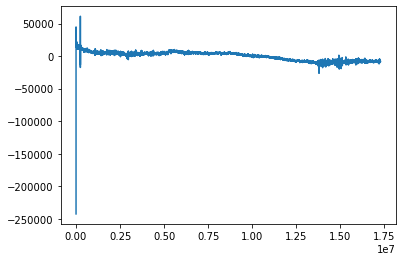

In [13]:
plt.plot(p0arr)

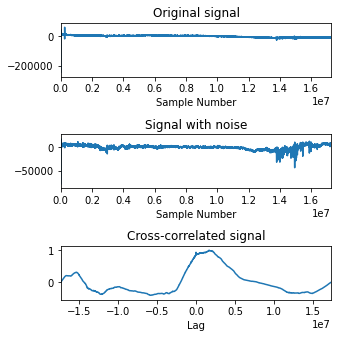

In [14]:
sig = p0arr
sig_noise = p1arr
from scipy import signal
corr = signal.correlate(p0arr, p1arr)
lags = signal.correlation_lags(len(p0arr), len(p1arr))
corr /= np.max(corr)

fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
ax_orig.plot(sig)
ax_orig.set_title('Original signal')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(sig_noise)
ax_noise.set_title('Signal with noise')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

(0.0, 30.0)

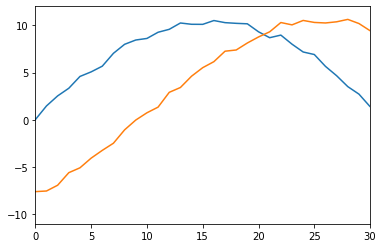

In [39]:
t = np.linspace(0,100, 1000)
v1 = 10* np.sin(t) + np.random.random(size = len(t))
v2 = 10*np.sin(t-1) + np.random.random(size = len(t))
plt.plot(v1)
plt.plot(v2)
plt.xlim(left = 0, right = 30)

In [32]:
def cross_corr(y1, y2):
  """Calculates the cross correlation and lags without normalization.

  The definition of the discrete cross-correlation is in:
  https://www.mathworks.com/help/matlab/ref/xcorr.html

  Args:
    y1, y2: Should have the same length.

  Returns:
    max_corr: Maximum correlation without normalization.
    lag: The lag in terms of the index.
  """
  if len(y1) != len(y2):
    raise ValueError('The lengths of the inputs should be the same.')

  y1_auto_corr = np.dot(y1, y1) / len(y1)
  y2_auto_corr = np.dot(y2, y2) / len(y1)
  corr = np.correlate(y1, y2, mode='same')
  # The unbiased sample size is N - lag.
  unbiased_sample_size = np.correlate(
      np.ones(len(y1)), np.ones(len(y1)), mode='same')
  corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
  shift = len(y1) // 2

  max_corr = np.max(corr)
  argmax_corr = np.argmax(corr)
  return max_corr, argmax_corr - shift

In [40]:
corr, lag = cross_corr(v1, v2)

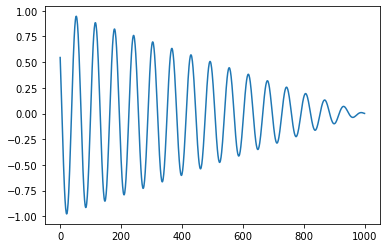

In [44]:
import statsmodels.api as sm
#calculate cross correlation
plt.plot(sm.tsa.stattools.ccf(v1, v2, adjusted=False))